In [129]:
#importing some useful packages
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
image_list = []
for filename in glob.glob('test_images/*.jpg'): #assuming gif
    im=cv2.imread(filename)
    image_list.append(im)
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


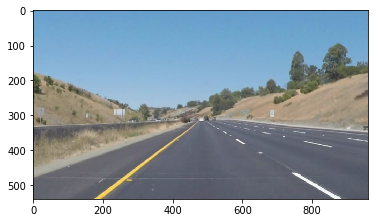

In [130]:
#reading in an image
image = image_list[5] #cv2.imread('test_images/solidYellowLeft.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

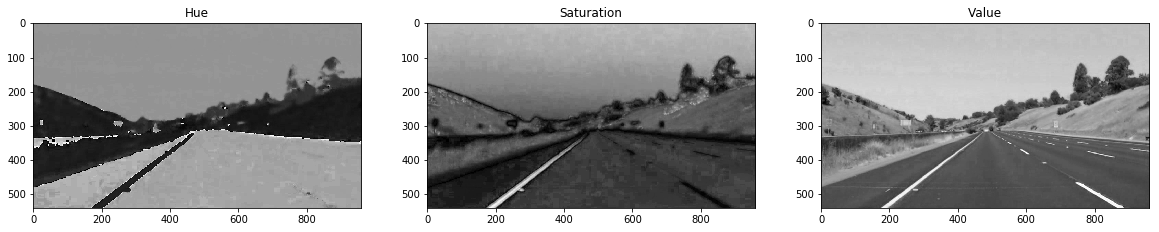

In [131]:
h = hsv[:,:,0]
s = hsv[:,:,1]
v = hsv[:,:,2]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))

ax1.set_title('Hue')
ax1.imshow(h, cmap='gray')

ax2.set_title('Saturation')
ax2.imshow(s, cmap='gray')

ax3.set_title('Value')
ax3.imshow(v, cmap='gray')

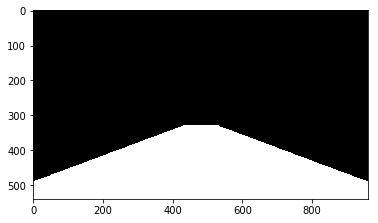

In [132]:
boundary = 330

base = np.zeros((image.shape[0], image.shape[1]))
trapezoid = np.copy(base)

polyPoints = np.array([[
    [0, 490],
    [430, boundary],
    [530, boundary],
    [960, 490],
    [960, 540],
    [0,   540]
]])

trapezoid = cv2.fillPoly(trapezoid, polyPoints, 100)
# 430 -> 530
plt.imshow(trapezoid, cmap='gray')

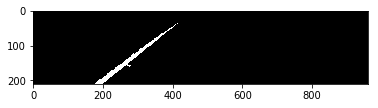

In [133]:

lower_hue = np.array([19,100, 0]) 
upper_hue = np.array([25,255,255])

# Define the masked area
mask1 = cv2.inRange(hsv[boundary:,:,:], lower_hue, upper_hue)
plt.imshow(mask1, cmap='gray')

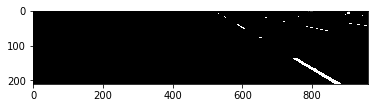

In [134]:
# 32
# 170
# 237
lower_rgb = np.array([0,0,200]) 
upper_rgb = np.array([255,30,255])

# Define the masked area
mask2 = cv2.inRange(hsv[boundary:,:,:], lower_rgb, upper_rgb)
plt.imshow(mask2, cmap='gray')

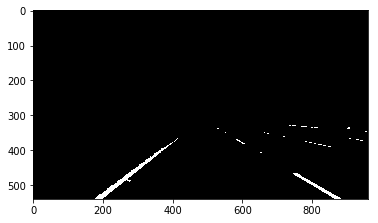

In [135]:
base[boundary:,:] = mask1+mask2
plt.imshow(base, cmap='gray')

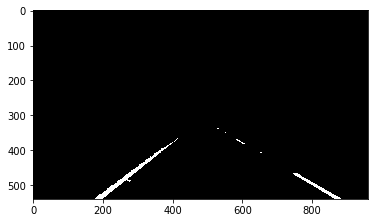

In [136]:
result = cv2.bitwise_and(base, trapezoid)
plt.imshow(result, cmap='gray')

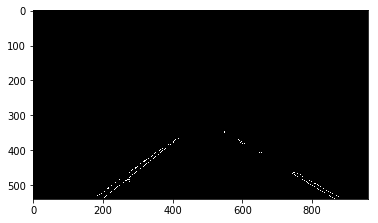

In [137]:
# Canny parmeters
low = 75
high = 100

image_edges = cv2.Canny(result.astype(np.uint8), low, high)

plt.imshow(image_edges, cmap="gray")

16
<class 'numpy.ndarray'>


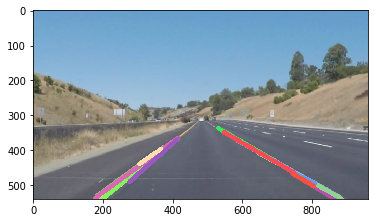

In [148]:
rho = 2
theta = np.pi/270
threshold = 15
min_line_length = 50
max_line_gap = 200

line_image = np.copy(image)

# run Hough on the edge-detected image
lines = cv2.HoughLinesP(image_edges, rho, theta, threshold, np.array([]),
                        min_line_length, max_line_gap)

print(len(lines))
from random import randrange
print(type(lines))
# iterate over the output "lines" and draw lines on the image copy
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(randrange(50, 255),randrange(50, 255),randrange(50, 255)),12)

plt.imshow(line_image)

# Remove weird extra dimension
lines = lines[:,0]

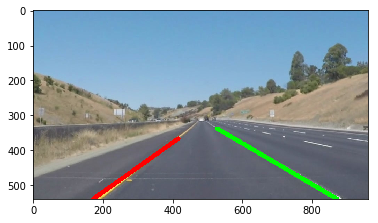

In [142]:
def slope(line):
    #x1,y1,x2,y2 = *line
    return (line[0]-line[2])/(line[1]-line[3])

def average_slope(lines):
    slopes = np.zeros(len(lines))
    for i, line in enumerate(lines):
        slopes[i] = slope(line)
    return np.average(slopes), slopes

def separate(lines):
    left = []
    right = []
    avg_slope, slopes = average_slope(lines)
    for i, line in enumerate(lines):
        if slopes[i] <= avg_slope:
            left.append(line)
        else:
            right.append(line)
    return np.array(left), np.array(right)

def unify_lines(lines):
    avg_slope = average_slope(lines)[0]
    start_point = lines[np.argmin(np.amin(lines[:,[1,3]], axis=1))]
    endX = round((540-start_point[1]) * avg_slope + start_point[0])
    offset = 2*np.argmin(start_point[[1,3]])
    return ((start_point[0+offset], start_point[1+offset]), (int(endX), 540))


left, right = separate(lines)
left  = unify_lines(left)
right = unify_lines(right)

lane_img = np.copy(image)

cv2.line(lane_img,  left[0],  left[1], (255,   0, 0),12)
cv2.line(lane_img, right[0], right[1], (  0, 255, 0),12)

plt.imshow(lane_img)
